<a href="https://colab.research.google.com/github/HarmanDotpy/ML-Assignment2/blob/main/Q3_3_MNIST_to_SVHN___SVHNtoMnist_generator_trained_1_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.FATAL)
import argparse, random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms


In [6]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 20)')
parser.add_argument('--num-k', type=int, default=4, metavar='N',
                    help='hyper paremeter for generator update')
parser.add_argument('--lr', type=float, default=0.0001, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args([])
use_cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
svhn_train_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='train', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

svhn_test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='test', download=True,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=True, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=False, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

Using downloaded and verified file: ./data/data_svhn/train_32x32.mat


Extracting ./data/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw


Extracting ./data/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw


Extracting ./data/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw





Extracting ./data/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw
Processing...
Done!


# MNIST  classifier trained on SVHN

### Our neural net

In [35]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64,kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)    
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [36]:
#  initializing the model
# model hyperparameters
num_epochs = 5
num_classes = 10
learning_rate = 0.001

model = ConvNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [37]:
# Training the model
totalsteps = len(mnist_train_loader)
losslist = []
accuracylist = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(mnist_train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if(i + 1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))

Epoch [1/5], Step [100/468], Loss: 0.1393, Accuracy: 96.09%
Epoch [1/5], Step [200/468], Loss: 0.1346, Accuracy: 95.31%
Epoch [1/5], Step [300/468], Loss: 0.0584, Accuracy: 97.66%
Epoch [1/5], Step [400/468], Loss: 0.1355, Accuracy: 96.88%
Epoch [2/5], Step [100/468], Loss: 0.0878, Accuracy: 96.88%
Epoch [2/5], Step [200/468], Loss: 0.0272, Accuracy: 99.22%
Epoch [2/5], Step [300/468], Loss: 0.0566, Accuracy: 98.44%
Epoch [2/5], Step [400/468], Loss: 0.0377, Accuracy: 98.44%
Epoch [3/5], Step [100/468], Loss: 0.0252, Accuracy: 99.22%
Epoch [3/5], Step [200/468], Loss: 0.0168, Accuracy: 99.22%
Epoch [3/5], Step [300/468], Loss: 0.0565, Accuracy: 99.22%
Epoch [3/5], Step [400/468], Loss: 0.0502, Accuracy: 98.44%
Epoch [4/5], Step [100/468], Loss: 0.0655, Accuracy: 99.22%
Epoch [4/5], Step [200/468], Loss: 0.0676, Accuracy: 96.88%
Epoch [4/5], Step [300/468], Loss: 0.0090, Accuracy: 99.22%
Epoch [4/5], Step [400/468], Loss: 0.0032, Accuracy: 100.00%
Epoch [5/5], Step [100/468], Loss: 0.04

In [38]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in mnist_test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for 10K test images = {} %'.format((correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')

Test Accuracy for 10K test images = 99.25 %


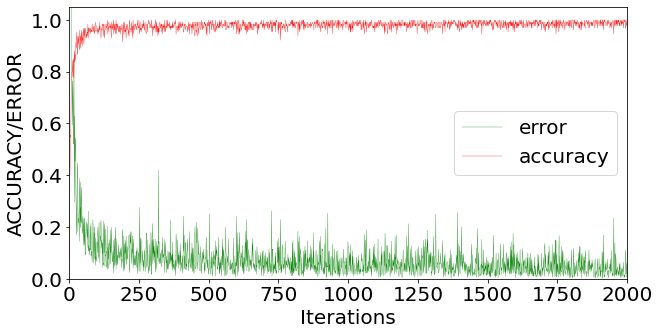

In [39]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.3, label = 'error')
plt.plot(accuracylist, color = 'red', linewidth = 0.3, label = 'accuracy')
plt.xlabel('Iterations', fontsize = 20)
plt.ylabel('ACCURACY/ERROR', fontsize = 20)
plt.xlim(0,2000)
plt.ylim(0,1.05)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

figure = plt.gcf()
figure.set_size_inches(10, 5)
plt.show()


### Testing on SVHN

In [40]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in svhn_test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(total, ( correct/total)*100))

Test Accuracy for 26000 test images = 22.46153846153846 %


# SVHN  classifier trained on mnist

### Our neural net

In [41]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 5, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64,kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)    
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [42]:
#  initializing the model
# model hyperparameters
num_epochs = 5
num_classes = 10
learning_rate = 0.001

model = ConvNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [43]:
# Training the model
totalsteps = len(mnist_train_loader)
losslist = []
accuracylist = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(svhn_train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if(i + 1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))

Epoch [1/5], Step [100/468], Loss: 1.2171, Accuracy: 60.94%
Epoch [1/5], Step [200/468], Loss: 1.0219, Accuracy: 68.75%
Epoch [1/5], Step [300/468], Loss: 0.7406, Accuracy: 80.47%
Epoch [1/5], Step [400/468], Loss: 0.6884, Accuracy: 77.34%
Epoch [1/5], Step [500/468], Loss: 0.8107, Accuracy: 77.34%
Epoch [2/5], Step [100/468], Loss: 0.6203, Accuracy: 79.69%
Epoch [2/5], Step [200/468], Loss: 0.5908, Accuracy: 85.16%
Epoch [2/5], Step [300/468], Loss: 0.5883, Accuracy: 80.47%
Epoch [2/5], Step [400/468], Loss: 0.5509, Accuracy: 82.03%
Epoch [2/5], Step [500/468], Loss: 0.6237, Accuracy: 78.91%
Epoch [3/5], Step [100/468], Loss: 0.4212, Accuracy: 89.06%
Epoch [3/5], Step [200/468], Loss: 0.5305, Accuracy: 87.50%
Epoch [3/5], Step [300/468], Loss: 0.6213, Accuracy: 79.69%
Epoch [3/5], Step [400/468], Loss: 0.6352, Accuracy: 83.59%
Epoch [3/5], Step [500/468], Loss: 0.7409, Accuracy: 81.25%
Epoch [4/5], Step [100/468], Loss: 0.5317, Accuracy: 84.38%
Epoch [4/5], Step [200/468], Loss: 0.599

In [44]:
## Testing SVHN classifier on SVHN test data

correct = 0
total = 0
model.eval()
with torch.no_grad():
  for images, labels in svhn_test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(total, (correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')

Test Accuracy for 26000 test images = 88.07692307692308 %


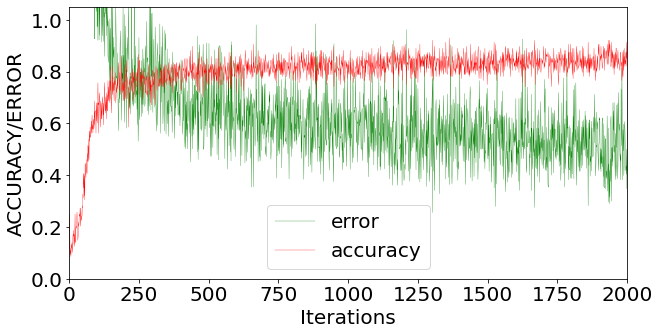

In [45]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.3, label = 'error')
plt.plot(accuracylist, color = 'red', linewidth = 0.3, label = 'accuracy')
plt.xlabel('Iterations', fontsize = 20)
plt.ylabel('ACCURACY/ERROR', fontsize = 20)
plt.xlim(0,2000)
plt.ylim(0,1.05)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

figure = plt.gcf()
figure.set_size_inches(10, 5)
plt.show()


### Testing on MNIST

In [46]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in mnist_test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(total, ( correct/total)*100))

Test Accuracy for 10000 test images = 57.21000000000001 %


# UDA
We will try to approaches

1.   Using cycle gan
2.   Implementing "Maximum Classifier Discrepancy for Unsupervised Domain Adaptation"

# Load both MNIST and SVHN datasets
Transformations are copied from the internet

In [2]:
svhn_train_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='train', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

svhn_test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='test', download=True,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=True, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=False, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

Extracting ./data/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw




Extracting ./data/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw


Extracting ./data/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw


Extracting ./data/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw
Processing...
Done!


GENERATOR

In [3]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(8192, 3072)
        self.bn1_fc = nn.BatchNorm1d(3072)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=3, padding=1)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=3, padding=1)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), 8192)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        return x

Network for classifiers F1 and F2 in paper

In [4]:
class Predictor(nn.Module):
    def __init__(self, prob=0.5):
        super(Predictor, self).__init__()
        # self.fc1 = nn.Linear(8192, 3072)
        # self.bn1_fc = nn.BatchNorm1d(3072)
        self.fc2 = nn.Linear(3072, 2048)
        self.bn2_fc = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 10)
        self.bn_fc3 = nn.BatchNorm1d(10)
        self.prob = prob

    def forward(self, x):
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_normal(m.weight)
    if type(m) == nn.Linear:
        nn.init.xavier_normal(m.weight)

In [6]:
G = Feature().apply(init_weights).to(device)
C1 = Predictor().apply(init_weights).to(device)
C2 = Predictor().apply(init_weights).to(device)

In [7]:
opt_G = optim.Adam(G.parameters(),lr=args.lr, weight_decay=0.0005)
opt_C1 = optim.Adam(C1.parameters(), lr=args.lr, weight_decay=0.0005)
opt_C2 = optim.Adam(C2.parameters(), lr=args.lr, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Training
we have MNIST train images, its labels and SVHN train images 

In [9]:
def train():
    G.train()
    C1.train()
    C2.train()
    
    def reset_grad():
        opt_G.zero_grad()
        opt_C1.zero_grad()
        opt_C2.zero_grad()
    
    def discrepancy(out1, out2):
        return torch.mean(torch.abs(F.softmax(out1)- F.softmax(out2)))

    data_zip = enumerate(zip(svhn_train_loader, mnist_train_loader))
    for batch_idx, ((img_s, label_s), (img_t,_)) in data_zip:
        img_t = img_t.to(device)
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        reset_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        
        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        
        loss_s.backward()
        opt_G.step()
        opt_C1.step()
        opt_C2.step()
        
        reset_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        feat_t = G(img_t)
        output_t1 = C1(feat_t)
        output_t2 = C2(feat_t)
        
        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        loss_dis = discrepancy(output_t1, output_t2)
        loss = loss_s - loss_dis
        
        loss.backward()
        opt_C1.step()
        opt_C2.step()
        
        reset_grad()
        
        for i in range(args.num_k):
            feature_t = G(img_t)
            output_t1 = C1(feature_t)
            output_t2 = C2(feature_t)
            loss_dis = discrepancy(output_t1, output_t2)
            loss_dis.backward()
            opt_G.step()
            reset_grad()
        
        if (batch_idx + 1) % args.log_interval == 0:
            print("Epoch: {}/{} [{}/{}]: Loss1: {:.5f}, Loss2: {:.5f}, Discrepancy: {:.5f}"
                 .format(epoch + 1, args.epochs, batch_idx + 1, min(len(svhn_train_loader), len(mnist_train_loader)), 
                         loss_s1.item(), loss_s2.item(), loss_dis.item()))

# Testing network on MNIST test samples as well as SVHN test samples

In [10]:
list_acc_mnist_train = []
list_acc_svhn_train = []
list_acc_svhn_test = []

def test():
    G.eval()
    C1.eval()
    C2.eval()


    correct = 0
    
    for (img_s, label_s) in mnist_test_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
        
    acc_mnist_train = 100. * correct / len(mnist_test_loader.dataset)
    
    
    correct = 0
    
    for (img_s, label_s) in svhn_train_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
    
    acc_svhn_train = 100. * correct / len(svhn_train_loader.dataset)
    
    
    correct = 0
    
    for (img_s, label_s) in svhn_test_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
    
    acc_svhn_test = 100. * correct / len(svhn_test_loader.dataset)
        
    print(
        '\nTest: MNIST Test: {:.0f}%, SVHN Train: {:.0f}%, SVHN Test: {:.0f}% \n'.format(
            acc_mnist_train, acc_svhn_train, acc_svhn_test))
    list_acc_mnist_train.append(acc_mnist_train)
    list_acc_svhn_train.append(acc_svhn_train)
    list_acc_svhn_test.append(acc_svhn_test)

In [11]:
for epoch in range(args.epochs):
    train()
    test()

Epoch: 1/20 [100/468]: Loss1: 0.64785, Loss2: 0.64690, Discrepancy: 0.01059
Epoch: 1/20 [200/468]: Loss1: 0.58602, Loss2: 0.60199, Discrepancy: 0.00826
Epoch: 1/20 [300/468]: Loss1: 0.33028, Loss2: 0.31561, Discrepancy: 0.00713
Epoch: 1/20 [400/468]: Loss1: 0.29785, Loss2: 0.29406, Discrepancy: 0.00778

Test: MNIST Test: 78%, SVHN Train: 67%, SVHN Test: 66% 

Epoch: 2/20 [100/468]: Loss1: 0.24538, Loss2: 0.23748, Discrepancy: 0.00571
Epoch: 2/20 [200/468]: Loss1: 0.23584, Loss2: 0.24984, Discrepancy: 0.00626
Epoch: 2/20 [300/468]: Loss1: 0.29300, Loss2: 0.30139, Discrepancy: 0.00423
Epoch: 2/20 [400/468]: Loss1: 0.16378, Loss2: 0.16637, Discrepancy: 0.00519

Test: MNIST Test: 81%, SVHN Train: 63%, SVHN Test: 63% 

Epoch: 3/20 [100/468]: Loss1: 0.08406, Loss2: 0.08123, Discrepancy: 0.00382
Epoch: 3/20 [200/468]: Loss1: 0.20878, Loss2: 0.18635, Discrepancy: 0.00318
Epoch: 3/20 [300/468]: Loss1: 0.20220, Loss2: 0.19429, Discrepancy: 0.00357
Epoch: 3/20 [400/468]: Loss1: 0.21638, Loss2: 0.

KeyboardInterrupt: ignored

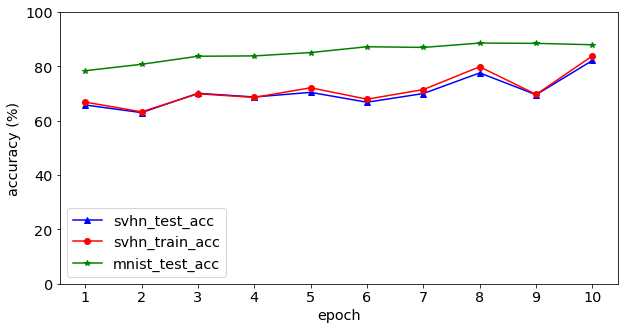

In [34]:

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots()
ax.plot(range(1, epoch + 1), list_acc_svhn_test, c = 'b', label = 'svhn_test_acc', marker = '^')
ax.plot(range(1, epoch + 1), list_acc_svhn_train, c = 'r', label = 'svhn_train_acc', marker = 'o')
ax.plot(range(1, epoch + 1), list_acc_mnist_train, label = 'mnist_test_acc', marker = '*', c = 'g')

ax.legend()
ax.set(xlabel='epoch', ylabel='accuracy (%)')
ax.set_ylim(0, 100)

plt.xticks(range(1, epoch + 1))
figure = plt.gcf()
figure.set_size_inches(10, 5)
plt.show()